## Importing Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Flatten
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product

## Loading Dataset

In [2]:
df = pd.read_csv('/content/final_merged_copper_dataset_new.csv')
df = df.drop(['Unnamed: 0'], axis=1)
df.head()

,Date,Price,Open,High,Low,Vol.,Change %,Month,Year,Real_GDP,CPI,inflation_rate,PALLFNFINDEXM
0,2023-10-05,3.5520,3.5830,3.6030,3.5490,58.69,1.03,10.0,2023.0,19374.0,NaN,6.6,NaN
1,2023-10-04,3.5890,3.6185,3.6220,3.5490,76.86,0.88,10.0,2023.0,19374.0,NaN,6.6,NaN
2,2023-10-03,3.6210,3.6480,3.6480,3.5815,69.45,0.56,10.0,2023.0,19374.0,NaN,6.6,NaN
3,2023-10-02,3.6415,3.7540,3.7615,3.6275,74.92,2.57,10.0,2023.0,19374.0,NaN,6.6,NaN
4,2023-09-29,3.7375,3.7125,3.7860,3.7115,82.33,0.80,9.0,2023.0,19374.0,NaN,6.6,NaN


In [3]:
df.tail()

,Date,Price,Open,High,Low,Vol.,Change %,Month,Year,Real_GDP,CPI,inflation_rate,PALLFNFINDEXM
2702,2013-01-07,3.6780,3.7035,3.7135,3.6525,39.01,0.03,1.0,2013.0,17812.167,232.166,1.464833,232.166
2703,2013-01-06,3.6790,3.6840,3.6900,3.6710,0.29,0.39,1.0,2013.0,17812.167,232.166,1.464833,232.166
2704,2013-01-04,3.6935,3.6935,3.7070,3.6710,45.82,0.63,1.0,2013.0,17812.167,232.166,1.464833,232.166
2705,2013-01-03,3.7170,3.7315,3.7590,3.6900,44.09,0.51,1.0,2013.0,17812.167,232.166,1.464833,232.166
2706,2013-01-02,3.7360,3.6510,3.7590,3.6440,48.42,2.29,1.0,2013.0,17812.167,232.166,1.464833,232.166


In [4]:
df.isnull().sum()

Date               0
Price              0
Open               0
High               0
Low                0
Vol.               0
Change %           0
Month              0
Year               0
Real_GDP           0
CPI               24
inflation_rate     0
PALLFNFINDEXM     24
dtype: int64

In [5]:
# Set a constant value for missing 'CPI' in the year 2023
constant_value_CPI_2023 = 307.0
# Fill the missing 'CPI' values with the constant value for 2023
df['CPI'] = df['CPI'].fillna(
    df['Year'].apply(lambda x: constant_value_CPI_2023 if x == 2023 else np.nan))

# Set a constant value for missing 'PALLFNFINDEXM' in the year 2023
constant_value_PALLFNFINDEXM_2023 = 161.45
# Fill the missing 'PALLFNFINDEXM' values with the constant value for 2023
df['PALLFNFINDEXM'] = df['PALLFNFINDEXM'].fillna(
    df['Year'].apply(lambda x: constant_value_PALLFNFINDEXM_2023 if x == 2023 else np.nan))

df.isnull().sum()

Date              0
Price             0
Open              0
High              0
Low               0
Vol.              0
Change %          0
Month             0
Year              0
Real_GDP          0
CPI               0
inflation_rate    0
PALLFNFINDEXM     0
dtype: int64

In [6]:
df = df.drop(['Month','Year'], axis=1)
df

,Date,Price,Open,High,Low,Vol.,Change %,Real_GDP,CPI,inflation_rate,PALLFNFINDEXM
0,2023-10-05,3.5520,3.5830,3.6030,3.5490,58.69,1.03,19374.000,307.000,6.600000,161.450
1,2023-10-04,3.5890,3.6185,3.6220,3.5490,76.86,0.88,19374.000,307.000,6.600000,161.450
2,2023-10-03,3.6210,3.6480,3.6480,3.5815,69.45,0.56,19374.000,307.000,6.600000,161.450
3,2023-10-02,3.6415,3.7540,3.7615,3.6275,74.92,2.57,19374.000,307.000,6.600000,161.450
4,2023-09-29,3.7375,3.7125,3.7860,3.7115,82.33,0.80,19374.000,307.000,6.600000,161.450
...,...,...,...,...,...,...,...,...,...,...,...
2702,2013-01-07,3.6780,3.7035,3.7135,3.6525,39.01,0.03,17812.167,232.166,1.464833,232.166
2703,2013-01-06,3.6790,3.6840,3.6900,3.6710,0.29,0.39,17812.167,232.166,1.464833,232.166
2704,2013-01-04,3.6935,3.6935,3.7070,3.6710,45.82,0.63,17812.167,232.166,1.464833,232.166
2705,2013-01-03,3.7170,3.7315,3.7590,3.6900,44.09,0.51,17812.167,232.166,1.464833,232.166


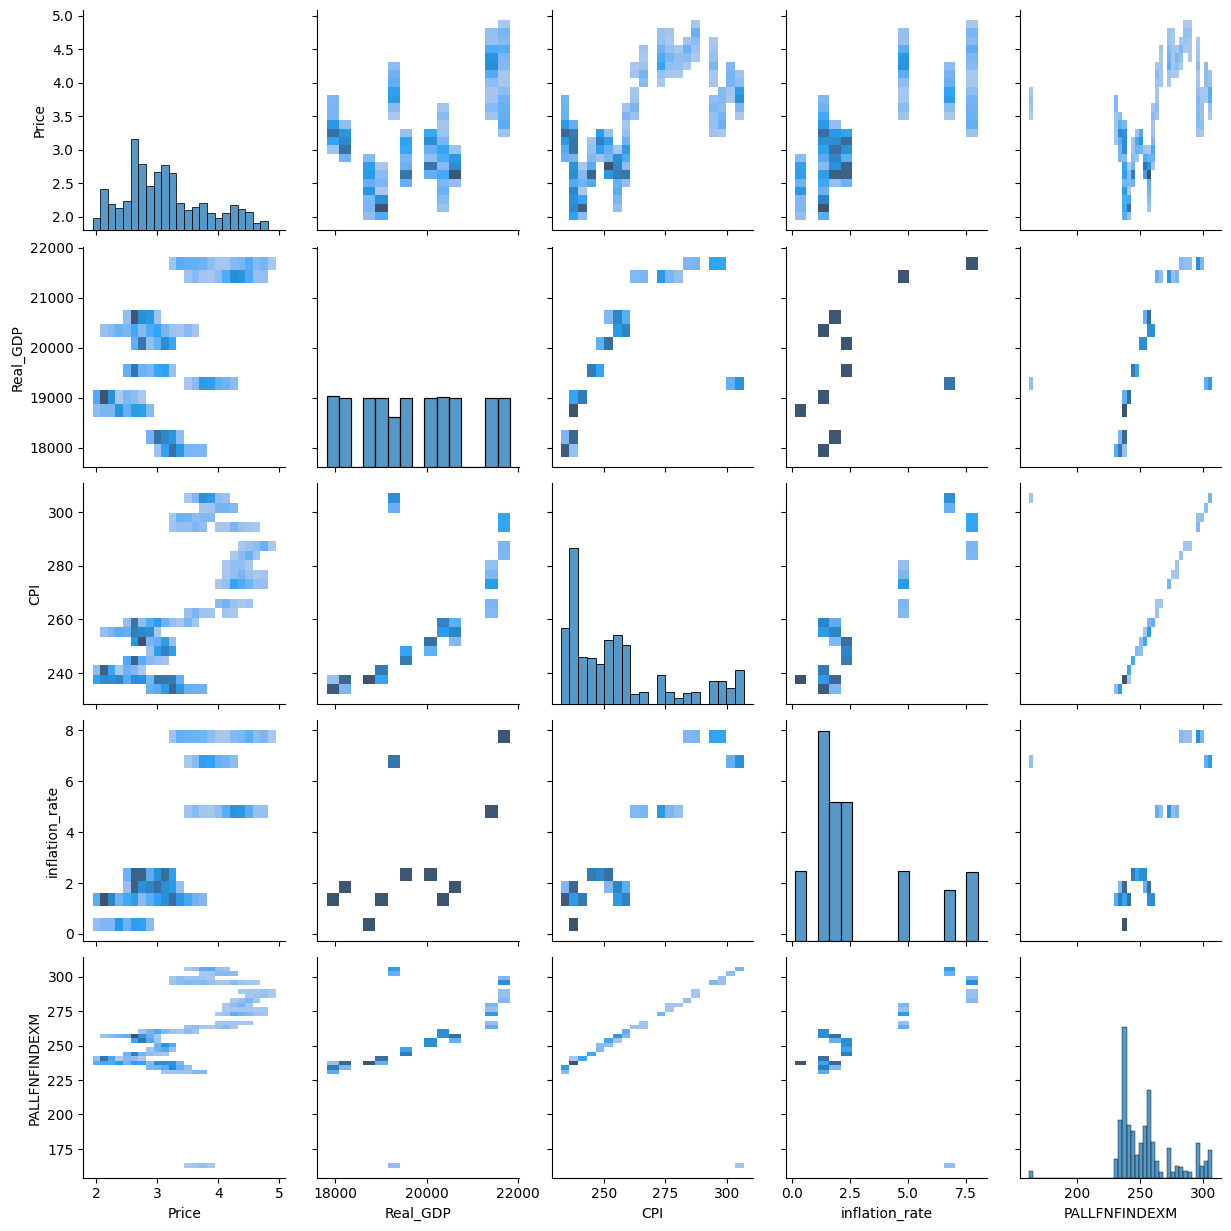

In [18]:
# Calling pairplot on our DataFrame for an automatic visual analysis
sns.pairplot(
    df[['Price','Real_GDP','CPI','inflation_rate','PALLFNFINDEXM']],
    kind="hist"
)
plt.show()

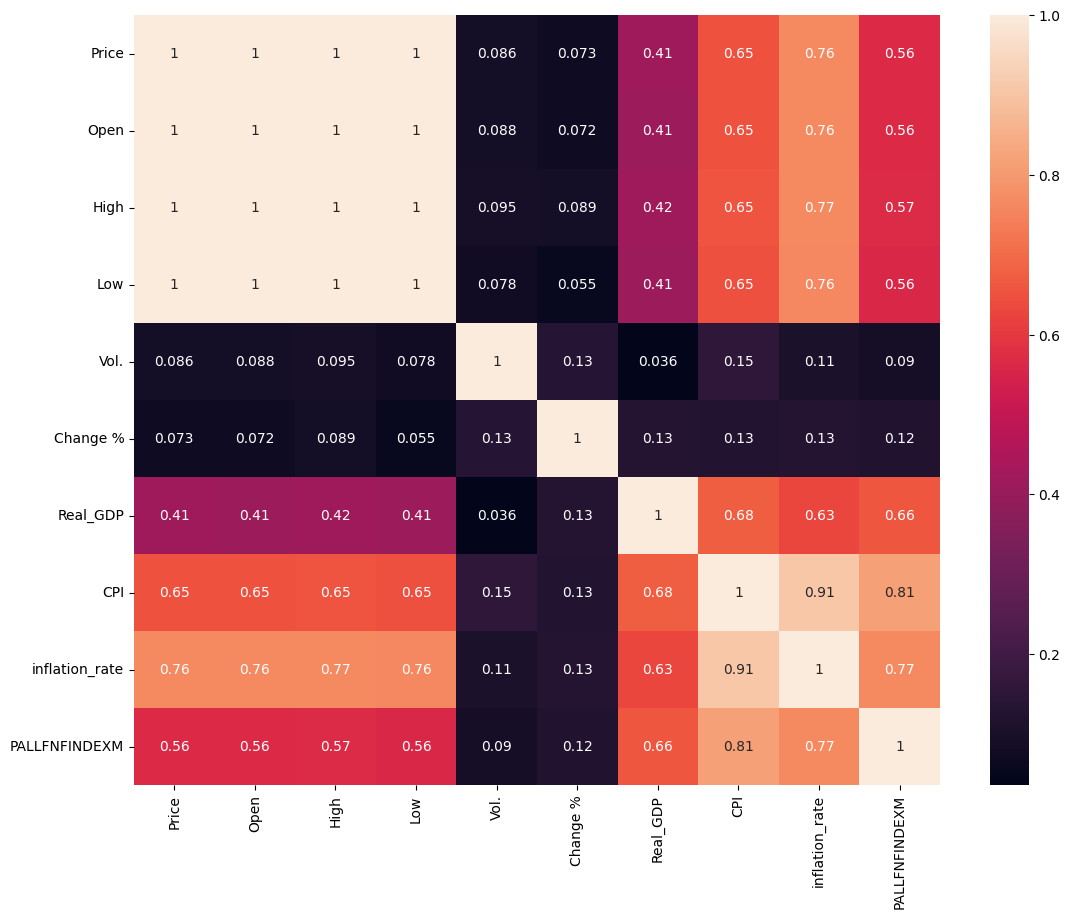

In [19]:
fig, ax = plt.subplots(figsize=(13,10))
sns.heatmap(df.corr(), ax=ax, annot=True)
plt.show();

## Data Preprocessing

In [7]:
# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

df.set_index('Date', inplace=True)
df

,Price,Open,High,Low,Vol.,Change %,Real_GDP,CPI,inflation_rate,PALLFNFINDEXM
Date,,,,,,,,,,
2023-10-05,3.5520,3.5830,3.6030,3.5490,58.69,1.03,19374.000,307.000,6.600000,161.450
2023-10-04,3.5890,3.6185,3.6220,3.5490,76.86,0.88,19374.000,307.000,6.600000,161.450
2023-10-03,3.6210,3.6480,3.6480,3.5815,69.45,0.56,19374.000,307.000,6.600000,161.450
2023-10-02,3.6415,3.7540,3.7615,3.6275,74.92,2.57,19374.000,307.000,6.600000,161.450
2023-09-29,3.7375,3.7125,3.7860,3.7115,82.33,0.80,19374.000,307.000,6.600000,161.450
...,...,...,...,...,...,...,...,...,...,...
2013-01-07,3.6780,3.7035,3.7135,3.6525,39.01,0.03,17812.167,232.166,1.464833,232.166
2013-01-06,3.6790,3.6840,3.6900,3.6710,0.29,0.39,17812.167,232.166,1.464833,232.166
2013-01-04,3.6935,3.6935,3.7070,3.6710,45.82,0.63,17812.167,232.166,1.464833,232.166


In [9]:
# # Normalize the data
# scaler = MinMaxScaler()
# scaled_target = scaler.fit_transform(df['Price'].values.reshape(-1, 1))
# scaled_features = scaler.fit_transform(df.drop(columns=['Price']))

In [12]:
# # Prepare sequences
# seq_length = 30
# X, y = [], []
# for i in range(len(df) - seq_length):
#     X.append(scaled_features[i:i + seq_length])
#     y.append(scaled_target[i + seq_length])

# X = np.array(X)
# y = np.array(y)

## Model

### Artificial Neural Network (ANN)

In [8]:
# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df)

In [9]:
# Split data into features (X) and target (y)
X = data_scaled[:, 1:]  # Exclude the first column if it's the target variable
y = data_scaled[:, 0]  # First column as the target variable

In [10]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [11]:
# Build the ANN model
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))  # Adjust activation function for regression

In [12]:
# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

In [13]:
# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
68/68 [==============================] - 1s 2ms/step - loss: 0.0068
Epoch 2/50
68/68 [==============================] - 0s 2ms/step - loss: 2.7183e-04
Epoch 3/50
68/68 [==============================] - 0s 2ms/step - loss: 1.2389e-04
Epoch 4/50
68/68 [==============================] - 0s 2ms/step - loss: 9.9295e-05
Epoch 5/50
68/68 [==============================] - 0s 2ms/step - loss: 8.6443e-05
Epoch 6/50
68/68 [==============================] - 0s 2ms/step - loss: 8.2535e-05
Epoch 7/50
68/68 [==============================] - 0s 2ms/step - loss: 8.7926e-05
Epoch 8/50
68/68 [==============================] - 0s 2ms/step - loss: 8.0441e-05
Epoch 9/50
68/68 [==============================] - 0s 2ms/step - loss: 8.3163e-05
Epoch 10/50
68/68 [==============================] - 0s 2ms/step - loss: 8.2208e-05
Epoch 11/50
68/68 [==============================] - 0s 2ms/step - loss: 8.0327e-05
Epoch 12/50
68/68 [==============================] - 0s 2ms/step - loss: 8.6563e-05
Epoch

In [14]:
# Make forecasts
y_pred = model.predict(X_test)

17/17 [==============================] - 0s 1ms/step


In [15]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 0.019367209486760118


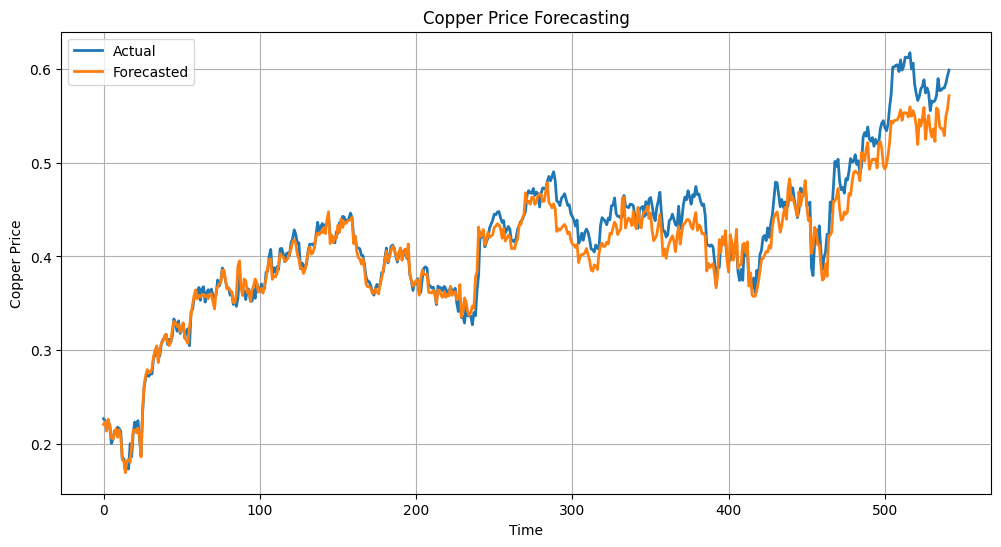

In [16]:
time_index = range(len(y_test))

# Plot actual and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(time_index, y_test, label="Actual", linestyle='-', linewidth=2)
plt.plot(time_index, y_pred, label="Forecasted", linestyle='-', linewidth=2)

plt.title("Copper Price Forecasting")
plt.xlabel("Time")
plt.ylabel("Copper Price")
plt.legend()
plt.grid(True)
plt.show()

In [17]:
model.save("models/ANN.h5")
print("Saved model to disk")

Saved model to disk


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Vector Autoregressor (VAR)

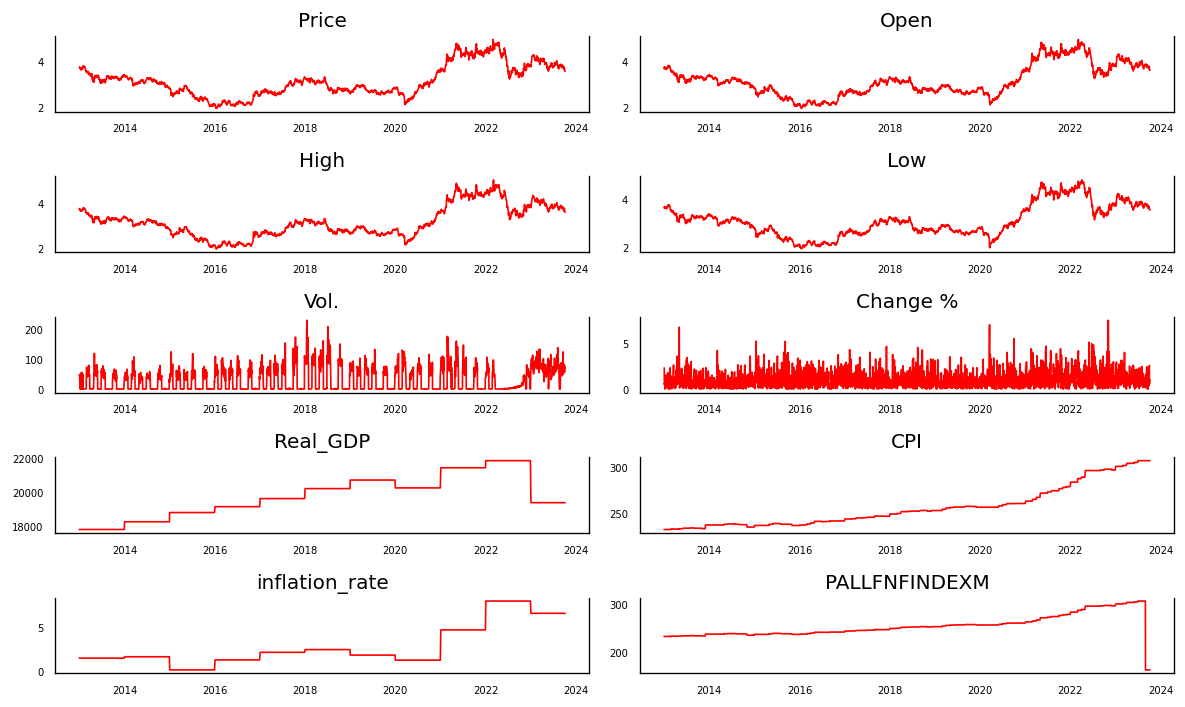

In [25]:
fig, axes = plt.subplots(nrows=5, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [26]:
# Check the shape of the DataFrame
print("Original DataFrame Shape:", df.shape)

Original DataFrame Shape: (2707, 10)


In [27]:
# If 'df' is not 2D, convert it to a 2D NumPy array
if len(df.shape) > 2:
    df_2d = df.values  # Convert 'df' to a 2D NumPy array
    print("Converted DataFrame to 2D NumPy Array Shape:", df_2d.shape)
else:
    df_2d = df  # 'df' is already 2D

In [28]:
data = df.values

In [29]:
# Split your data into a training set and a test set
train_size = int(len(data) * 0.8)
train, test = data[0:train_size], data[train_size:]

In [30]:
model = VAR(data)  # 'data' is your 2D array of time series data
best_lag_order = model.select_order(15)  # Choose a maximum lag order
print("Selected Lag Order:", best_lag_order.selected_orders)

Selected Lag Order: {'aic': 3, 'bic': 1, 'hqic': 1, 'fpe': 3}


In [31]:
# Fit the VAR model
model = VAR(train)
model_fitted = model.fit(10)

In [32]:
# Forecast
forecast = model_fitted.forecast(train[-model_fitted.k_ar:], steps=len(test))

In [33]:
forecast

array([[2.61670839e+00, 2.60784645e+00, 2.63847081e+00, ...,
        2.36628547e+02, 1.42774327e-01, 2.36448821e+02],
       [2.60758920e+00, 2.60978276e+00, 2.63345688e+00, ...,
        2.36573613e+02, 1.65583885e-01, 2.36463517e+02],
       [2.60661217e+00, 2.60800655e+00, 2.63187399e+00, ...,
        2.36553424e+02, 1.82227307e-01, 2.35991381e+02],
       ...,
       [2.09927400e+00, 2.10007107e+00, 2.11691906e+00, ...,
        2.33939067e+02, 2.64592747e-02, 2.33870340e+02],
       [2.09916965e+00, 2.09996735e+00, 2.11681426e+00, ...,
        2.33939886e+02, 2.65382114e-02, 2.33871100e+02],
       [2.09906612e+00, 2.09986446e+00, 2.11671029e+00, ...,
        2.33940709e+02, 2.66181320e-02, 2.33871865e+02]])

In [36]:
# Calculate RMSE
# rmse_value = rmse(test, forecast)
# print(f"Root Mean Squared Error (RMSE): {rmse_value}")

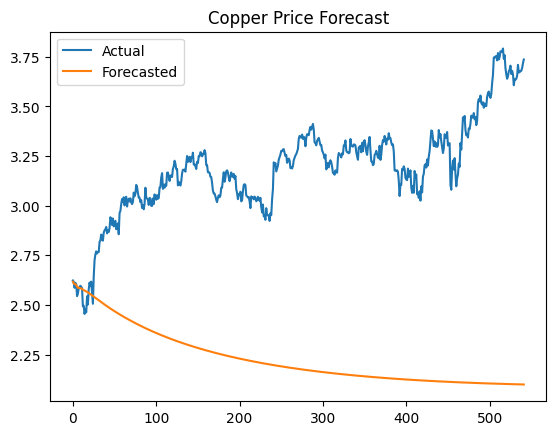

In [35]:
# Plot the actual and forecasted copper prices
plt.plot(test[:, 0], label="Actual")
plt.plot(forecast[:, 0], label="Forecasted")
plt.title("Copper Price Forecast")
plt.legend()
plt.show()

### LSTM - CNN

In [37]:
# Build the LSTM-CNN model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(seq_length, len(df.columns.drop('Price')))))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [38]:
# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

Epoch 1/50


ValueError: ignored

In [39]:
# Evaluate the model
y_pred = model.predict(X_test)

ValueError: ignored

In [ ]:
# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

In [ ]:
# Calculate RMSE
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")

In [ ]:
# Plot actual vs. forecasted values
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual")
plt.plot(y_pred, label="Forecasted")
plt.title("Actual vs. Forecasted Copper Prices")
plt.xlabel("Time")
plt.ylabel("Copper Price")
plt.legend()
plt.show()